<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [IMDB3] - Sentiment analysis with a LSTM network
<!-- DESC --> Still the same problem, but with a network combining embedding and LSTM
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - The objective is to guess whether film reviews are **positive or negative** based on the analysis of the text. 
 - Use of a model combining embedding and LSTM

Original dataset can be find **[there](http://ai.stanford.edu/~amaas/data/sentiment/)**  
Note that [IMDb.com](https://imdb.com) offers several easy-to-use [datasets](https://www.imdb.com/interfaces/)  
For simplicity's sake, we'll use the dataset directly [embedded in Keras](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

## What we're going to do :

 - Retrieve data
 - Preparing the data
 - Build a Embedding/LSTM model
 - Train the model
 - Evaluate the result


## Step 1 - Init python stuff

In [1]:
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.datasets.imdb as imdb

import matplotlib.pyplot as plt
import matplotlib

import os,sys,h5py,json
from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('IMDB3')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.7
Notebook id          : IMDB3
Run time             : Wednesday 27 January 2021, 19:12:17
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


## Step 2 - Retrieve data

IMDb dataset can bet get directly from Keras - see [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  
Note : Due to their nature, textual data can be somewhat complex.

### 2.1 - Data structure :  
The dataset is composed of 2 parts: 

 - **reviews**, this will be our **x**
 - **opinions** (positive/negative), this will be our **y**

There are also a **dictionary**, because words are indexed in reviews

```
<dataset> = (<reviews>, <opinions>)

with :  <reviews>  = [ <review1>, <review2>, ... ]
        <opinions> = [ <rate1>,   <rate2>,   ... ]   where <ratei>   = integer

where : <reviewi> = [ <w1>, <w2>, ...]    <wi> are the index (int) of the word in the dictionary
        <ratei>   = int                   0 for negative opinion, 1 for positive


<dictionary> = [ <word1>:<w1>, <word2>:<w2>, ... ]

with :  <wordi>   = word
        <wi>      = int

```

### 2.2 - Get dataset
For simplicity, we will use a pre-formatted dataset - See [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data)  
However, Keras offers some usefull tools for formatting textual data - See [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text)  

**Load dataset :**

In [2]:
vocab_size = 10000

# ----- Retrieve x,y

# Uncomment this if you want to load dataset directly from keras (small size <20M)
#
(x_train, y_train), (x_test, y_test) = imdb.load_data( num_words  = vocab_size,
                                                       skip_top   = 0,
                                                       maxlen     = None,
                                                       seed       = 42,
                                                       start_char = 1,
                                                       oov_char   = 2,
                                                       index_from = 3, )

# To load a h5 version of the dataset :
#
# with  h5py.File(f'{datasets_dir}/IMDB/origine/dataset_imdb.h5','r') as f:
#        x_train = f['x_train'][:]
#        y_train = f['y_train'][:]
#        x_test  = f['x_test'][:]
#        y_test  = f['y_test'][:]

**About this dataset :**

In [3]:
print("  Max(x_train,x_test)  : ", pwk.rmax([x_train,x_test]) )
print("  x_train : {}  y_train : {}".format(x_train.shape, y_train.shape))
print("  x_test  : {}  y_test  : {}".format(x_test.shape,  y_test.shape))

print('\nReview example (x_train[12]) :\n\n',x_train[12])

  Max(x_train,x_test)  :  9999
  x_train : (25000,)  y_train : (25000,)
  x_test  : (25000,)  y_test  : (25000,)

Review example (x_train[12]) :

 [1, 14, 22, 1367, 53, 206, 159, 4, 636, 898, 74, 26, 11, 436, 363, 108, 7, 14, 432, 14, 22, 9, 1055, 34, 8599, 2, 5, 381, 3705, 4509, 14, 768, 47, 839, 25, 111, 1517, 2579, 1991, 438, 2663, 587, 4, 280, 725, 6, 58, 11, 2714, 201, 4, 206, 16, 702, 5, 5176, 19, 480, 5920, 157, 13, 64, 219, 4, 2, 11, 107, 665, 1212, 39, 4, 206, 4, 65, 410, 16, 565, 5, 24, 43, 343, 17, 5602, 8, 169, 101, 85, 206, 108, 8, 3008, 14, 25, 215, 168, 18, 6, 2579, 1991, 438, 2, 11, 129, 1609, 36, 26, 66, 290, 3303, 46, 5, 633, 115, 4363]


### 2.3 - Have a look for humans (optional)
When we loaded the dataset, we asked for using \<start\> as 1, \<unknown word\> as 2  
So, we shifted the dataset by 3 with the parameter index_from=3

**Load dictionary :**

In [4]:
# ---- Retrieve dictionary {word:index}, and encode it in ascii
#
word_index = imdb.get_word_index()

# ---- Shift the dictionary from +3
#
word_index = {w:(i+3) for w,i in word_index.items()}

# ---- Add <pad>, <start> and unknown tags
#
word_index.update( {'<pad>':0, '<start>':1, '<unknown>':2} )

# ---- Create a reverse dictionary : {index:word}
#
index_word = {index:word for word,index in word_index.items()} 

# ---- Add a nice function to transpose :
#
def dataset2text(review):
    return ' '.join([index_word.get(i, '?') for i in review])

**Have a look :**

In [5]:
print('\nDictionary size     : ', len(word_index))
for k in range(440,455):print(f'{k:2d} : {index_word[k]}' )
pwk.subtitle('Review example :')
print(x_train[12])
pwk.subtitle('After translation :')
print(dataset2text(x_train[12]))


Dictionary size     :  88587
440 : hope
441 : entertaining
442 : she's
443 : mr
444 : overall
445 : evil
446 : called
447 : loved
448 : based
449 : oh
450 : several
451 : fans
452 : mother
453 : drama
454 : beginning


<br>**Review example :**

[1, 14, 22, 1367, 53, 206, 159, 4, 636, 898, 74, 26, 11, 436, 363, 108, 7, 14, 432, 14, 22, 9, 1055, 34, 8599, 2, 5, 381, 3705, 4509, 14, 768, 47, 839, 25, 111, 1517, 2579, 1991, 438, 2663, 587, 4, 280, 725, 6, 58, 11, 2714, 201, 4, 206, 16, 702, 5, 5176, 19, 480, 5920, 157, 13, 64, 219, 4, 2, 11, 107, 665, 1212, 39, 4, 206, 4, 65, 410, 16, 565, 5, 24, 43, 343, 17, 5602, 8, 169, 101, 85, 206, 108, 8, 3008, 14, 25, 215, 168, 18, 6, 2579, 1991, 438, 2, 11, 129, 1609, 36, 26, 66, 290, 3303, 46, 5, 633, 115, 4363]


<br>**After translation :**

<start> this film contains more action before the opening credits than are in entire hollywood films of this sort this film is produced by tsui <unknown> and stars jet li this team has brought you many worthy hong kong cinema productions including the once upon a time in china series the action was fast and furious with amazing wire work i only saw the <unknown> in two shots aside from the action the story itself was strong and not just used as filler to find any other action films to rival this you must look for a hong kong cinema <unknown> in your area they are really worth checking out and usually never disappoint


### 2.4 - Have a look for NN

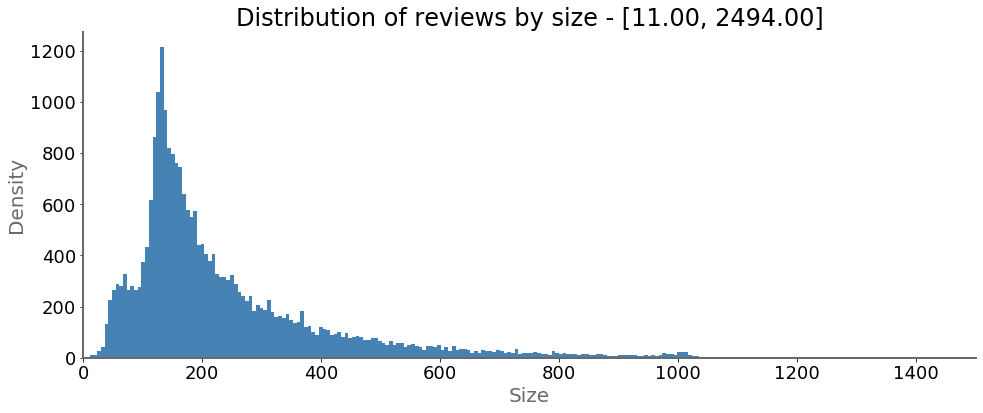

In [6]:
sizes=[len(i) for i in x_train]
plt.figure(figsize=(16,6))
plt.hist(sizes, bins=400)
plt.gca().set(title='Distribution of reviews by size - [{:5.2f}, {:5.2f}]'.format(min(sizes),max(sizes)), 
              xlabel='Size', ylabel='Density', xlim=[0,1500])
pwk.save_fig('01-stats-sizes')
plt.show()

## Step 3 - Preprocess the data (padding)
In order to be processed by an NN, all entries must have the **same length.**  
We chose a review length of **review_len**  
We will therefore complete them with a padding (of \<pad\>\)  

In [7]:
review_len = 256

x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                     value   = 0,
                                                     padding = 'post',
                                                     maxlen  = review_len)

x_test  = keras.preprocessing.sequence.pad_sequences(x_test,
                                                     value   = 0 ,
                                                     padding = 'post',
                                                     maxlen  = review_len)

pwk.subtitle('After padding :')
print(x_train[12])
pwk.subtitle('In real words :')
print(dataset2text(x_train[12]))

<br>**After padding :**

[   1   14   22 1367   53  206  159    4  636  898   74   26   11  436
  363  108    7   14  432   14   22    9 1055   34 8599    2    5  381
 3705 4509   14  768   47  839   25  111 1517 2579 1991  438 2663  587
    4  280  725    6   58   11 2714  201    4  206   16  702    5 5176
   19  480 5920  157   13   64  219    4    2   11  107  665 1212   39
    4  206    4   65  410   16  565    5   24   43  343   17 5602    8
  169  101   85  206  108    8 3008   14   25  215  168   18    6 2579
 1991  438    2   11  129 1609   36   26   66  290 3303   46    5  633
  115 4363    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

<br>**In real words :**

<start> this film contains more action before the opening credits than are in entire hollywood films of this sort this film is produced by tsui <unknown> and stars jet li this team has brought you many worthy hong kong cinema productions including the once upon a time in china series the action was fast and furious with amazing wire work i only saw the <unknown> in two shots aside from the action the story itself was strong and not just used as filler to find any other action films to rival this you must look for a hong kong cinema <unknown> in your area they are really worth checking out and usually never disappoint <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pa

**Save dataset and dictionary (For future use but not mandatory)**

In [8]:
# ---- Write dataset in a h5 file, could be usefull
#
output_dir = './data'
pwk.mkdir(output_dir)

with h5py.File(f'{output_dir}/dataset_imdb.h5', 'w') as f:
    f.create_dataset("x_train",    data=x_train)
    f.create_dataset("y_train",    data=y_train)
    f.create_dataset("x_test",     data=x_test)
    f.create_dataset("y_test",     data=y_test)

with open(f'{output_dir}/word_index.json', 'w') as fp:
    json.dump(word_index, fp)

with open(f'{output_dir}/index_word.json', 'w') as fp:
    json.dump(index_word, fp)

print('Saved.')

Saved.


## Step 4 - Build the model
Few remarks :
 - We'll choose a dense vector size for the embedding output with **dense_vector_size**
 - **GlobalAveragePooling1D** do a pooling on the last dimension : (None, lx, ly) -> (None, ly)  
   In other words: we average the set of vectors/words of a sentence
 - L'embedding de Keras fonctionne de manière supervisée. Il s'agit d'une couche de *vocab_size* neurones vers *n_neurons* permettant de maintenir une table de vecteurs (les poids constituent les vecteurs). Cette couche ne calcule pas de sortie a la façon des couches normales, mais renvois la valeur des vecteurs. n mots => n vecteurs (ensuite empilés par le pooling)  
Voir : [Explication plus détaillée (en)](https://stats.stackexchange.com/questions/324992/how-the-embedding-layer-is-trained-in-keras-embedding-layer)  
ainsi que : [Sentiment detection with Keras](https://www.liip.ch/en/blog/sentiment-detection-with-keras-word-embeddings-and-lstm-deep-learning-networks)  

More documentation about this model functions :
 - [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)
 - [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D)

In [9]:
def get_model(dense_vector_size=128):
    
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim    = vocab_size, 
                                     output_dim   = dense_vector_size, 
                                     input_length = review_len))
    model.add(keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(keras.layers.Dense(1,                 activation='sigmoid'))

    model.compile(optimizer = 'adam',
                  loss      = 'binary_crossentropy',
                  metrics   = ['accuracy'])
    return model

## Step 5 - Train the model
### 5.1 - Get it

In [10]:
model = get_model(32)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 32)           320000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 402,561
Trainable params: 402,561
Non-trainable params: 0
_________________________________________________________________


### 5.2 - Add callback

In [11]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_model.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 5.1 - Train it
GPU : batch_size=512 :  6' 30s  
CPU : batch_size=512 : 12' 57s

In [12]:
%%time

n_epochs   = 10
batch_size = 512

history = model.fit(x_train,
                    y_train,
                    epochs          = n_epochs,
                    batch_size      = batch_size,
                    validation_data = (x_test, y_test),
                    verbose         = 1,
                    callbacks       = [savemodel_callback])


Epoch 1/10


 1/49 [..............................] - ETA: 0s - loss: 0.6934 - accuracy: 0.4883

 2/49 [>.............................] - ETA: 15s - loss: 0.6932 - accuracy: 0.4951

 3/49 [>.............................] - ETA: 19s - loss: 0.6929 - accuracy: 0.5059

 4/49 [=>............................] - ETA: 21s - loss: 0.6931 - accuracy: 0.5024

 5/49 [==>...........................] - ETA: 21s - loss: 0.6932 - accuracy: 0.5008

 6/49 [==>...........................] - ETA: 22s - loss: 0.6937 - accuracy: 0.4919

 7/49 [===>..........................] - ETA: 22s - loss: 0.6937 - accuracy: 0.4922

 8/49 [===>..........................] - ETA: 22s - loss: 0.6936 - accuracy: 0.4956

 9/49 [====>.........................] - ETA: 21s - loss: 0.6935 - accuracy: 0.4996

10/49 [=====>........................] - ETA: 21s - loss: 0.6935 - accuracy: 0.5008

11/49 [=====>........................] - ETA: 21s - loss: 0.6935 - accuracy: 0.4979

12/49 [======>.......................] - ETA: 20s - loss: 0.6934 - accuracy: 0.4993

13/49 [======>.......................] - ETA: 20s - loss: 0.6934 - accuracy: 0.4967

14/49 [=======>......................] - ETA: 20s - loss: 0.6933 - accuracy: 0.4964

15/49 [========>.....................] - ETA: 19s - loss: 0.6933 - accuracy: 0.4967

16/49 [========>.....................] - ETA: 19s - loss: 0.6933 - accuracy: 0.4982

17/49 [=========>....................] - ETA: 18s - loss: 0.6932 - accuracy: 0.4993

18/49 [==========>...................] - ETA: 18s - loss: 0.6933 - accuracy: 0.4996

19/49 [==========>...................] - ETA: 17s - loss: 0.6932 - accuracy: 0.5013

20/49 [===========>..................] - ETA: 17s - loss: 0.6932 - accuracy: 0.5031

21/49 [===========>..................] - ETA: 16s - loss: 0.6931 - accuracy: 0.5062

22/49 [============>.................] - ETA: 15s - loss: 0.6931 - accuracy: 0.5055

23/49 [=============>................] - ETA: 15s - loss: 0.6931 - accuracy: 0.5071

24/49 [=============>................] - ETA: 14s - loss: 0.6930 - accuracy: 0.5098

25/49 [==============>...............] - ETA: 14s - loss: 0.6930 - accuracy: 0.5104

26/49 [==============>...............] - ETA: 13s - loss: 0.6930 - accuracy: 0.5113

27/49 [===============>..............] - ETA: 13s - loss: 0.6929 - accuracy: 0.5135

28/49 [================>.............] - ETA: 12s - loss: 0.6929 - accuracy: 0.5135

29/49 [================>.............] - ETA: 11s - loss: 0.6929 - accuracy: 0.5151

30/49 [=================>............] - ETA: 11s - loss: 0.6928 - accuracy: 0.5161

31/49 [=================>............] - ETA: 10s - loss: 0.6928 - accuracy: 0.5164

32/49 [==================>...........] - ETA: 10s - loss: 0.6928 - accuracy: 0.5175

33/49 [===================>..........] - ETA: 9s - loss: 0.6928 - accuracy: 0.5181 

34/49 [===================>..........] - ETA: 8s - loss: 0.6928 - accuracy: 0.5190

35/49 [====================>.........] - ETA: 8s - loss: 0.6927 - accuracy: 0.5188

36/49 [=====================>........] - ETA: 7s - loss: 0.6927 - accuracy: 0.5186

37/49 [=====================>........] - ETA: 7s - loss: 0.6927 - accuracy: 0.5180

38/49 [======================>.......] - ETA: 6s - loss: 0.6926 - accuracy: 0.5190

39/49 [======================>.......] - ETA: 6s - loss: 0.6925 - accuracy: 0.5184

40/49 [=======================>......] - ETA: 5s - loss: 0.6922 - accuracy: 0.5201

41/49 [========================>.....] - ETA: 4s - loss: 0.6922 - accuracy: 0.5200

42/49 [========================>.....] - ETA: 4s - loss: 0.6926 - accuracy: 0.5181

43/49 [=========================>....] - ETA: 3s - loss: 0.6924 - accuracy: 0.5195

44/49 [=========================>....] - ETA: 3s - loss: 0.6922 - accuracy: 0.5219

45/49 [==========================>...] - ETA: 2s - loss: 0.6921 - accuracy: 0.5222

46/49 [===========================>..] - ETA: 1s - loss: 0.6921 - accuracy: 0.5222

47/49 [===========================>..] - ETA: 1s - loss: 0.6920 - accuracy: 0.5230

48/49 [============================>.] - ETA: 0s - loss: 0.6918 - accuracy: 0.5243

49/49 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.5247

49/49 [==============================] - 33s 679ms/step - loss: 0.6918 - accuracy: 0.5247 - val_loss: 0.6886 - val_accuracy: 0.5529


Epoch 2/10


 1/49 [..............................] - ETA: 0s - loss: 0.6810 - accuracy: 0.6211

 2/49 [>.............................] - ETA: 14s - loss: 0.6838 - accuracy: 0.5928

 3/49 [>.............................] - ETA: 18s - loss: 0.6839 - accuracy: 0.5853

 4/49 [=>............................] - ETA: 20s - loss: 0.6829 - accuracy: 0.5923

 5/49 [==>...........................] - ETA: 21s - loss: 0.6831 - accuracy: 0.5871

 6/49 [==>...........................] - ETA: 21s - loss: 0.6837 - accuracy: 0.5801

 7/49 [===>..........................] - ETA: 22s - loss: 0.6832 - accuracy: 0.5781

 8/49 [===>..........................] - ETA: 22s - loss: 0.6823 - accuracy: 0.5776

 9/49 [====>.........................] - ETA: 21s - loss: 0.6806 - accuracy: 0.5801

10/49 [=====>........................] - ETA: 21s - loss: 0.6808 - accuracy: 0.5752

11/49 [=====>........................] - ETA: 21s - loss: 0.6795 - accuracy: 0.5771

12/49 [======>.......................] - ETA: 20s - loss: 0.6792 - accuracy: 0.5801

13/49 [======>.......................] - ETA: 20s - loss: 0.6791 - accuracy: 0.5795

14/49 [=======>......................] - ETA: 20s - loss: 0.6792 - accuracy: 0.5816

15/49 [========>.....................] - ETA: 19s - loss: 0.6793 - accuracy: 0.5797

16/49 [========>.....................] - ETA: 19s - loss: 0.6792 - accuracy: 0.5812

17/49 [=========>....................] - ETA: 18s - loss: 0.6792 - accuracy: 0.5824

18/49 [==========>...................] - ETA: 18s - loss: 0.6791 - accuracy: 0.5825

19/49 [==========>...................] - ETA: 17s - loss: 0.6792 - accuracy: 0.5809

20/49 [===========>..................] - ETA: 16s - loss: 0.6794 - accuracy: 0.5801

21/49 [===========>..................] - ETA: 16s - loss: 0.6795 - accuracy: 0.5793

22/49 [============>.................] - ETA: 15s - loss: 0.6796 - accuracy: 0.5784

23/49 [=============>................] - ETA: 15s - loss: 0.6794 - accuracy: 0.5773

24/49 [=============>................] - ETA: 14s - loss: 0.6796 - accuracy: 0.5756

25/49 [==============>...............] - ETA: 14s - loss: 0.6795 - accuracy: 0.5749

26/49 [==============>...............] - ETA: 13s - loss: 0.6795 - accuracy: 0.5729

27/49 [===============>..............] - ETA: 13s - loss: 0.6795 - accuracy: 0.5728

28/49 [================>.............] - ETA: 12s - loss: 0.6794 - accuracy: 0.5720

29/49 [================>.............] - ETA: 11s - loss: 0.6795 - accuracy: 0.5711

30/49 [=================>............] - ETA: 11s - loss: 0.6794 - accuracy: 0.5708

31/49 [=================>............] - ETA: 10s - loss: 0.6794 - accuracy: 0.5707

32/49 [==================>...........] - ETA: 10s - loss: 0.6792 - accuracy: 0.5709

33/49 [===================>..........] - ETA: 9s - loss: 0.6792 - accuracy: 0.5701 

34/49 [===================>..........] - ETA: 8s - loss: 0.6791 - accuracy: 0.5702

35/49 [====================>.........] - ETA: 8s - loss: 0.6790 - accuracy: 0.5693

36/49 [=====================>........] - ETA: 7s - loss: 0.6789 - accuracy: 0.5694

37/49 [=====================>........] - ETA: 7s - loss: 0.6785 - accuracy: 0.5698

38/49 [======================>.......] - ETA: 6s - loss: 0.6784 - accuracy: 0.5696

39/49 [======================>.......] - ETA: 5s - loss: 0.6785 - accuracy: 0.5687

40/49 [=======================>......] - ETA: 5s - loss: 0.6783 - accuracy: 0.5690

41/49 [========================>.....] - ETA: 4s - loss: 0.6782 - accuracy: 0.5685

42/49 [========================>.....] - ETA: 4s - loss: 0.6780 - accuracy: 0.5681

43/49 [=========================>....] - ETA: 3s - loss: 0.6776 - accuracy: 0.5680

44/49 [=========================>....] - ETA: 3s - loss: 0.6773 - accuracy: 0.5684

45/49 [==========================>...] - ETA: 2s - loss: 0.6769 - accuracy: 0.5683

46/49 [===========================>..] - ETA: 1s - loss: 0.6764 - accuracy: 0.5687

47/49 [===========================>..] - ETA: 1s - loss: 0.6754 - accuracy: 0.5701

48/49 [============================>.] - ETA: 0s - loss: 0.6861 - accuracy: 0.5693

49/49 [==============================] - ETA: 0s - loss: 0.6854 - accuracy: 0.5704

49/49 [==============================] - 33s 668ms/step - loss: 0.6854 - accuracy: 0.5704 - val_loss: 0.6652 - val_accuracy: 0.5736


Epoch 3/10


 1/49 [..............................] - ETA: 0s - loss: 0.6523 - accuracy: 0.6172

 2/49 [>.............................] - ETA: 14s - loss: 0.6587 - accuracy: 0.5918

 3/49 [>.............................] - ETA: 18s - loss: 0.6631 - accuracy: 0.5755

 4/49 [=>............................] - ETA: 20s - loss: 0.6648 - accuracy: 0.5737

 5/49 [==>...........................] - ETA: 21s - loss: 0.6648 - accuracy: 0.5770

 6/49 [==>...........................] - ETA: 22s - loss: 0.6665 - accuracy: 0.5723

 7/49 [===>..........................] - ETA: 22s - loss: 0.6676 - accuracy: 0.5698

 8/49 [===>..........................] - ETA: 22s - loss: 0.6674 - accuracy: 0.5703

 9/49 [====>.........................] - ETA: 21s - loss: 0.6683 - accuracy: 0.5694

10/49 [=====>........................] - ETA: 21s - loss: 0.6689 - accuracy: 0.5676

11/49 [=====>........................] - ETA: 21s - loss: 0.6696 - accuracy: 0.5643

12/49 [======>.......................] - ETA: 20s - loss: 0.6693 - accuracy: 0.5669

13/49 [======>.......................] - ETA: 20s - loss: 0.6696 - accuracy: 0.5667

14/49 [=======>......................] - ETA: 19s - loss: 0.6705 - accuracy: 0.5649

15/49 [========>.....................] - ETA: 19s - loss: 0.6713 - accuracy: 0.5625

16/49 [========>.....................] - ETA: 19s - loss: 0.6715 - accuracy: 0.5616

17/49 [=========>....................] - ETA: 18s - loss: 0.6717 - accuracy: 0.5607

18/49 [==========>...................] - ETA: 18s - loss: 0.6714 - accuracy: 0.5621

19/49 [==========>...................] - ETA: 17s - loss: 0.6716 - accuracy: 0.5606

20/49 [===========>..................] - ETA: 16s - loss: 0.6715 - accuracy: 0.5600

21/49 [===========>..................] - ETA: 16s - loss: 0.6714 - accuracy: 0.5605

22/49 [============>.................] - ETA: 15s - loss: 0.6714 - accuracy: 0.5600

23/49 [=============>................] - ETA: 15s - loss: 0.6718 - accuracy: 0.5587

24/49 [=============>................] - ETA: 14s - loss: 0.6714 - accuracy: 0.5605

25/49 [==============>...............] - ETA: 14s - loss: 0.6714 - accuracy: 0.5605

26/49 [==============>...............] - ETA: 13s - loss: 0.6717 - accuracy: 0.5589

27/49 [===============>..............] - ETA: 13s - loss: 0.6717 - accuracy: 0.5592

28/49 [================>.............] - ETA: 12s - loss: 0.6716 - accuracy: 0.5598

29/49 [================>.............] - ETA: 11s - loss: 0.6718 - accuracy: 0.5585

30/49 [=================>............] - ETA: 11s - loss: 0.6720 - accuracy: 0.5574

31/49 [=================>............] - ETA: 10s - loss: 0.6719 - accuracy: 0.5575

32/49 [==================>...........] - ETA: 10s - loss: 0.6718 - accuracy: 0.5569

33/49 [===================>..........] - ETA: 9s - loss: 0.6720 - accuracy: 0.5557 

34/49 [===================>..........] - ETA: 8s - loss: 0.6719 - accuracy: 0.5554

35/49 [====================>.........] - ETA: 8s - loss: 0.6715 - accuracy: 0.5562

36/49 [=====================>........] - ETA: 7s - loss: 0.6714 - accuracy: 0.5561

37/49 [=====================>........] - ETA: 7s - loss: 0.6714 - accuracy: 0.5556

38/49 [======================>.......] - ETA: 6s - loss: 0.6712 - accuracy: 0.5554

39/49 [======================>.......] - ETA: 5s - loss: 0.6713 - accuracy: 0.5545

40/49 [=======================>......] - ETA: 5s - loss: 0.6712 - accuracy: 0.5539

41/49 [========================>.....] - ETA: 4s - loss: 0.6711 - accuracy: 0.5537

42/49 [========================>.....] - ETA: 4s - loss: 0.6709 - accuracy: 0.5535

43/49 [=========================>....] - ETA: 3s - loss: 0.6705 - accuracy: 0.5536

44/49 [=========================>....] - ETA: 2s - loss: 0.6703 - accuracy: 0.5528

45/49 [==========================>...] - ETA: 2s - loss: 0.6701 - accuracy: 0.5533

46/49 [===========================>..] - ETA: 1s - loss: 0.6699 - accuracy: 0.5538

47/49 [===========================>..] - ETA: 1s - loss: 0.6698 - accuracy: 0.5535

48/49 [============================>.] - ETA: 0s - loss: 0.6695 - accuracy: 0.5537

49/49 [==============================] - ETA: 0s - loss: 0.6694 - accuracy: 0.5538

49/49 [==============================] - 33s 664ms/step - loss: 0.6694 - accuracy: 0.5538 - val_loss: 0.6708 - val_accuracy: 0.5484


Epoch 4/10


 1/49 [..............................] - ETA: 0s - loss: 0.6482 - accuracy: 0.5723

 2/49 [>.............................] - ETA: 14s - loss: 0.6530 - accuracy: 0.5732

 3/49 [>.............................] - ETA: 18s - loss: 0.6586 - accuracy: 0.5677

 4/49 [=>............................] - ETA: 21s - loss: 0.6596 - accuracy: 0.5679

 5/49 [==>...........................] - ETA: 21s - loss: 0.6584 - accuracy: 0.5777

 6/49 [==>...........................] - ETA: 22s - loss: 0.6577 - accuracy: 0.5768

 7/49 [===>..........................] - ETA: 22s - loss: 0.6571 - accuracy: 0.5812

 8/49 [===>..........................] - ETA: 22s - loss: 0.6566 - accuracy: 0.5833

 9/49 [====>.........................] - ETA: 22s - loss: 0.6566 - accuracy: 0.5844

10/49 [=====>........................] - ETA: 21s - loss: 0.6566 - accuracy: 0.5820

11/49 [=====>........................] - ETA: 21s - loss: 0.6568 - accuracy: 0.5794

12/49 [======>.......................] - ETA: 20s - loss: 0.6553 - accuracy: 0.5801

13/49 [======>.......................] - ETA: 20s - loss: 0.6554 - accuracy: 0.5771

14/49 [=======>......................] - ETA: 20s - loss: 0.6548 - accuracy: 0.5776

15/49 [========>.....................] - ETA: 19s - loss: 0.6538 - accuracy: 0.5805

16/49 [========>.....................] - ETA: 19s - loss: 0.6530 - accuracy: 0.5809

17/49 [=========>....................] - ETA: 18s - loss: 0.6527 - accuracy: 0.5809

18/49 [==========>...................] - ETA: 18s - loss: 0.6520 - accuracy: 0.5824

19/49 [==========>...................] - ETA: 17s - loss: 0.6510 - accuracy: 0.5832

20/49 [===========>..................] - ETA: 17s - loss: 0.6494 - accuracy: 0.5863

21/49 [===========>..................] - ETA: 16s - loss: 0.6477 - accuracy: 0.5889

22/49 [============>.................] - ETA: 15s - loss: 0.6449 - accuracy: 0.5935

23/49 [=============>................] - ETA: 15s - loss: 0.6427 - accuracy: 0.6019

24/49 [=============>................] - ETA: 14s - loss: 0.6399 - accuracy: 0.6064

25/49 [==============>...............] - ETA: 14s - loss: 0.6373 - accuracy: 0.6092

26/49 [==============>...............] - ETA: 13s - loss: 0.6361 - accuracy: 0.6104

27/49 [===============>..............] - ETA: 13s - loss: 0.6327 - accuracy: 0.6147

28/49 [================>.............] - ETA: 12s - loss: 0.6265 - accuracy: 0.6221

29/49 [================>.............] - ETA: 11s - loss: 0.6224 - accuracy: 0.6280

30/49 [=================>............] - ETA: 11s - loss: 0.6202 - accuracy: 0.6320

31/49 [=================>............] - ETA: 10s - loss: 0.6146 - accuracy: 0.6376

32/49 [==================>...........] - ETA: 10s - loss: 0.6110 - accuracy: 0.6415

33/49 [===================>..........] - ETA: 9s - loss: 0.6078 - accuracy: 0.6459 

34/49 [===================>..........] - ETA: 8s - loss: 0.6040 - accuracy: 0.6502

35/49 [====================>.........] - ETA: 8s - loss: 0.5995 - accuracy: 0.6550

36/49 [=====================>........] - ETA: 7s - loss: 0.5946 - accuracy: 0.6602

37/49 [=====================>........] - ETA: 7s - loss: 0.5919 - accuracy: 0.6634

38/49 [======================>.......] - ETA: 6s - loss: 0.5892 - accuracy: 0.6666

39/49 [======================>.......] - ETA: 6s - loss: 0.5846 - accuracy: 0.6709

40/49 [=======================>......] - ETA: 5s - loss: 0.5805 - accuracy: 0.6751

41/49 [========================>.....] - ETA: 4s - loss: 0.5767 - accuracy: 0.6794

42/49 [========================>.....] - ETA: 4s - loss: 0.5722 - accuracy: 0.6835

43/49 [=========================>....] - ETA: 3s - loss: 0.5685 - accuracy: 0.6868

44/49 [=========================>....] - ETA: 3s - loss: 0.5648 - accuracy: 0.6904

45/49 [==========================>...] - ETA: 2s - loss: 0.5611 - accuracy: 0.6941

46/49 [===========================>..] - ETA: 1s - loss: 0.5580 - accuracy: 0.6971

47/49 [===========================>..] - ETA: 1s - loss: 0.5543 - accuracy: 0.7001

48/49 [============================>.] - ETA: 0s - loss: 0.5505 - accuracy: 0.7035

49/49 [==============================] - ETA: 0s - loss: 0.5487 - accuracy: 0.7055

49/49 [==============================] - 33s 667ms/step - loss: 0.5487 - accuracy: 0.7055 - val_loss: 0.3964 - val_accuracy: 0.8437


Epoch 5/10


 1/49 [..............................] - ETA: 0s - loss: 0.3503 - accuracy: 0.8730

 2/49 [>.............................] - ETA: 14s - loss: 0.3613 - accuracy: 0.8662

 3/49 [>.............................] - ETA: 18s - loss: 0.3635 - accuracy: 0.8620

 4/49 [=>............................] - ETA: 20s - loss: 0.3715 - accuracy: 0.8599

 5/49 [==>...........................] - ETA: 21s - loss: 0.3697 - accuracy: 0.8625

 6/49 [==>...........................] - ETA: 21s - loss: 0.3766 - accuracy: 0.8613

 7/49 [===>..........................] - ETA: 22s - loss: 0.3738 - accuracy: 0.8624

 8/49 [===>..........................] - ETA: 22s - loss: 0.3691 - accuracy: 0.8625

 9/49 [====>.........................] - ETA: 21s - loss: 0.3707 - accuracy: 0.8609

10/49 [=====>........................] - ETA: 21s - loss: 0.3751 - accuracy: 0.8570

11/49 [=====>........................] - ETA: 21s - loss: 0.3799 - accuracy: 0.8564

12/49 [======>.......................] - ETA: 20s - loss: 0.3862 - accuracy: 0.8537

13/49 [======>.......................] - ETA: 20s - loss: 0.3844 - accuracy: 0.8547

14/49 [=======>......................] - ETA: 20s - loss: 0.3803 - accuracy: 0.8569

15/49 [========>.....................] - ETA: 19s - loss: 0.3812 - accuracy: 0.8570

16/49 [========>.....................] - ETA: 19s - loss: 0.3794 - accuracy: 0.8583

17/49 [=========>....................] - ETA: 18s - loss: 0.3793 - accuracy: 0.8586

18/49 [==========>...................] - ETA: 18s - loss: 0.3799 - accuracy: 0.8590

19/49 [==========>...................] - ETA: 17s - loss: 0.3791 - accuracy: 0.8598

20/49 [===========>..................] - ETA: 16s - loss: 0.3799 - accuracy: 0.8598

21/49 [===========>..................] - ETA: 16s - loss: 0.3812 - accuracy: 0.8587

22/49 [============>.................] - ETA: 15s - loss: 0.3798 - accuracy: 0.8595

23/49 [=============>................] - ETA: 15s - loss: 0.3782 - accuracy: 0.8603

24/49 [=============>................] - ETA: 14s - loss: 0.3757 - accuracy: 0.8615

25/49 [==============>...............] - ETA: 14s - loss: 0.3758 - accuracy: 0.8617

26/49 [==============>...............] - ETA: 13s - loss: 0.3735 - accuracy: 0.8628

27/49 [===============>..............] - ETA: 13s - loss: 0.3719 - accuracy: 0.8639

28/49 [================>.............] - ETA: 12s - loss: 0.3724 - accuracy: 0.8637

29/49 [================>.............] - ETA: 11s - loss: 0.3736 - accuracy: 0.8630

30/49 [=================>............] - ETA: 11s - loss: 0.3721 - accuracy: 0.8637

31/49 [=================>............] - ETA: 10s - loss: 0.3745 - accuracy: 0.8628

32/49 [==================>...........] - ETA: 10s - loss: 0.3757 - accuracy: 0.8622

33/49 [===================>..........] - ETA: 9s - loss: 0.3742 - accuracy: 0.8631 

34/49 [===================>..........] - ETA: 8s - loss: 0.3732 - accuracy: 0.8635

35/49 [====================>.........] - ETA: 8s - loss: 0.3715 - accuracy: 0.8642

36/49 [=====================>........] - ETA: 7s - loss: 0.3702 - accuracy: 0.8646

37/49 [=====================>........] - ETA: 7s - loss: 0.3702 - accuracy: 0.8647

38/49 [======================>.......] - ETA: 6s - loss: 0.3693 - accuracy: 0.8651

39/49 [======================>.......] - ETA: 6s - loss: 0.3686 - accuracy: 0.8655

40/49 [=======================>......] - ETA: 5s - loss: 0.3678 - accuracy: 0.8659

41/49 [========================>.....] - ETA: 4s - loss: 0.3668 - accuracy: 0.8662

42/49 [========================>.....] - ETA: 4s - loss: 0.3665 - accuracy: 0.8665

43/49 [=========================>....] - ETA: 3s - loss: 0.3671 - accuracy: 0.8663

44/49 [=========================>....] - ETA: 3s - loss: 0.3676 - accuracy: 0.8660

45/49 [==========================>...] - ETA: 2s - loss: 0.3674 - accuracy: 0.8661

46/49 [===========================>..] - ETA: 1s - loss: 0.3661 - accuracy: 0.8668

47/49 [===========================>..] - ETA: 1s - loss: 0.3653 - accuracy: 0.8672

48/49 [============================>.] - ETA: 0s - loss: 0.3650 - accuracy: 0.8674

49/49 [==============================] - ETA: 0s - loss: 0.3648 - accuracy: 0.8676

49/49 [==============================] - 33s 666ms/step - loss: 0.3648 - accuracy: 0.8676 - val_loss: 0.3880 - val_accuracy: 0.8526


Epoch 6/10


 1/49 [..............................] - ETA: 0s - loss: 0.3395 - accuracy: 0.8809

 2/49 [>.............................] - ETA: 14s - loss: 0.3132 - accuracy: 0.8916

 3/49 [>.............................] - ETA: 18s - loss: 0.3243 - accuracy: 0.8880

 4/49 [=>............................] - ETA: 20s - loss: 0.3290 - accuracy: 0.8853

 5/49 [==>...........................] - ETA: 21s - loss: 0.3250 - accuracy: 0.8887

 6/49 [==>...........................] - ETA: 21s - loss: 0.3223 - accuracy: 0.8893

 7/49 [===>..........................] - ETA: 22s - loss: 0.3232 - accuracy: 0.8881

 8/49 [===>..........................] - ETA: 22s - loss: 0.3380 - accuracy: 0.8821

 9/49 [====>.........................] - ETA: 21s - loss: 0.3559 - accuracy: 0.8767

10/49 [=====>........................] - ETA: 21s - loss: 0.3676 - accuracy: 0.8734

11/49 [=====>........................] - ETA: 21s - loss: 0.3685 - accuracy: 0.8741

12/49 [======>.......................] - ETA: 20s - loss: 0.3703 - accuracy: 0.8737

13/49 [======>.......................] - ETA: 20s - loss: 0.3678 - accuracy: 0.8748

14/49 [=======>......................] - ETA: 19s - loss: 0.3647 - accuracy: 0.8770

15/49 [========>.....................] - ETA: 19s - loss: 0.3611 - accuracy: 0.8788

16/49 [========>.....................] - ETA: 19s - loss: 0.3613 - accuracy: 0.8782

17/49 [=========>....................] - ETA: 18s - loss: 0.3613 - accuracy: 0.8779

18/49 [==========>...................] - ETA: 18s - loss: 0.3618 - accuracy: 0.8772

19/49 [==========>...................] - ETA: 17s - loss: 0.3622 - accuracy: 0.8764

20/49 [===========>..................] - ETA: 16s - loss: 0.3602 - accuracy: 0.8771

21/49 [===========>..................] - ETA: 16s - loss: 0.3590 - accuracy: 0.8777

22/49 [============>.................] - ETA: 15s - loss: 0.3574 - accuracy: 0.8785

23/49 [=============>................] - ETA: 15s - loss: 0.3560 - accuracy: 0.8787

24/49 [=============>................] - ETA: 14s - loss: 0.3549 - accuracy: 0.8792

25/49 [==============>...............] - ETA: 14s - loss: 0.3558 - accuracy: 0.8788

26/49 [==============>...............] - ETA: 13s - loss: 0.3563 - accuracy: 0.8789

27/49 [===============>..............] - ETA: 13s - loss: 0.3559 - accuracy: 0.8788

28/49 [================>.............] - ETA: 12s - loss: 0.3549 - accuracy: 0.8793

29/49 [================>.............] - ETA: 11s - loss: 0.3558 - accuracy: 0.8789

30/49 [=================>............] - ETA: 11s - loss: 0.3551 - accuracy: 0.8793

31/49 [=================>............] - ETA: 10s - loss: 0.3564 - accuracy: 0.8785

32/49 [==================>...........] - ETA: 10s - loss: 0.3554 - accuracy: 0.8788

33/49 [===================>..........] - ETA: 9s - loss: 0.3532 - accuracy: 0.8799 

34/49 [===================>..........] - ETA: 8s - loss: 0.3520 - accuracy: 0.8803

35/49 [====================>.........] - ETA: 8s - loss: 0.3512 - accuracy: 0.8809

36/49 [=====================>........] - ETA: 7s - loss: 0.3510 - accuracy: 0.8810

37/49 [=====================>........] - ETA: 7s - loss: 0.3503 - accuracy: 0.8815

38/49 [======================>.......] - ETA: 6s - loss: 0.3495 - accuracy: 0.8817

39/49 [======================>.......] - ETA: 6s - loss: 0.3488 - accuracy: 0.8821

40/49 [=======================>......] - ETA: 5s - loss: 0.3485 - accuracy: 0.8825

41/49 [========================>.....] - ETA: 4s - loss: 0.3467 - accuracy: 0.8835

42/49 [========================>.....] - ETA: 4s - loss: 0.3462 - accuracy: 0.8837

43/49 [=========================>....] - ETA: 3s - loss: 0.3458 - accuracy: 0.8838

44/49 [=========================>....] - ETA: 3s - loss: 0.3445 - accuracy: 0.8842

45/49 [==========================>...] - ETA: 2s - loss: 0.3435 - accuracy: 0.8846

46/49 [===========================>..] - ETA: 1s - loss: 0.3442 - accuracy: 0.8843

47/49 [===========================>..] - ETA: 1s - loss: 0.3456 - accuracy: 0.8837

48/49 [============================>.] - ETA: 0s - loss: 0.3486 - accuracy: 0.8825

49/49 [==============================] - ETA: 0s - loss: 0.3513 - accuracy: 0.8814

49/49 [==============================] - 33s 667ms/step - loss: 0.3513 - accuracy: 0.8814 - val_loss: 0.4956 - val_accuracy: 0.8177


Epoch 7/10


 1/49 [..............................] - ETA: 0s - loss: 0.4610 - accuracy: 0.8320

 2/49 [>.............................] - ETA: 15s - loss: 0.4037 - accuracy: 0.8525

 3/49 [>.............................] - ETA: 19s - loss: 0.3731 - accuracy: 0.8672

 4/49 [=>............................] - ETA: 20s - loss: 0.3521 - accuracy: 0.8784

 5/49 [==>...........................] - ETA: 21s - loss: 0.3470 - accuracy: 0.8793

 6/49 [==>...........................] - ETA: 22s - loss: 0.3416 - accuracy: 0.8825

 7/49 [===>..........................] - ETA: 22s - loss: 0.3373 - accuracy: 0.8850

 8/49 [===>..........................] - ETA: 22s - loss: 0.3360 - accuracy: 0.8857

 9/49 [====>.........................] - ETA: 21s - loss: 0.3421 - accuracy: 0.8839

10/49 [=====>........................] - ETA: 21s - loss: 0.3453 - accuracy: 0.8836

11/49 [=====>........................] - ETA: 21s - loss: 0.3475 - accuracy: 0.8819

12/49 [======>.......................] - ETA: 20s - loss: 0.3443 - accuracy: 0.8835

13/49 [======>.......................] - ETA: 20s - loss: 0.3465 - accuracy: 0.8833

14/49 [=======>......................] - ETA: 19s - loss: 0.3470 - accuracy: 0.8828

15/49 [========>.....................] - ETA: 19s - loss: 0.3441 - accuracy: 0.8842

16/49 [========>.....................] - ETA: 18s - loss: 0.3433 - accuracy: 0.8846

17/49 [=========>....................] - ETA: 18s - loss: 0.3439 - accuracy: 0.8841

18/49 [==========>...................] - ETA: 17s - loss: 0.3460 - accuracy: 0.8831

19/49 [==========>...................] - ETA: 17s - loss: 0.3431 - accuracy: 0.8845

20/49 [===========>..................] - ETA: 16s - loss: 0.3432 - accuracy: 0.8845

21/49 [===========>..................] - ETA: 16s - loss: 0.3438 - accuracy: 0.8845

22/49 [============>.................] - ETA: 15s - loss: 0.3404 - accuracy: 0.8859

23/49 [=============>................] - ETA: 15s - loss: 0.3393 - accuracy: 0.8864

24/49 [=============>................] - ETA: 14s - loss: 0.3376 - accuracy: 0.8872

25/49 [==============>...............] - ETA: 14s - loss: 0.3361 - accuracy: 0.8880

26/49 [==============>...............] - ETA: 13s - loss: 0.3371 - accuracy: 0.8875

27/49 [===============>..............] - ETA: 12s - loss: 0.3359 - accuracy: 0.8878

28/49 [================>.............] - ETA: 12s - loss: 0.3365 - accuracy: 0.8873

29/49 [================>.............] - ETA: 11s - loss: 0.3351 - accuracy: 0.8876

30/49 [=================>............] - ETA: 11s - loss: 0.3357 - accuracy: 0.8874

31/49 [=================>............] - ETA: 10s - loss: 0.3358 - accuracy: 0.8875

32/49 [==================>...........] - ETA: 10s - loss: 0.3350 - accuracy: 0.8882

33/49 [===================>..........] - ETA: 9s - loss: 0.3345 - accuracy: 0.8885 

34/49 [===================>..........] - ETA: 8s - loss: 0.3336 - accuracy: 0.8889

35/49 [====================>.........] - ETA: 8s - loss: 0.3338 - accuracy: 0.8888

36/49 [=====================>........] - ETA: 7s - loss: 0.3332 - accuracy: 0.8892

37/49 [=====================>........] - ETA: 7s - loss: 0.3322 - accuracy: 0.8896

38/49 [======================>.......] - ETA: 6s - loss: 0.3321 - accuracy: 0.8898

39/49 [======================>.......] - ETA: 5s - loss: 0.3327 - accuracy: 0.8894

40/49 [=======================>......] - ETA: 5s - loss: 0.3372 - accuracy: 0.8878

41/49 [========================>.....] - ETA: 4s - loss: 0.3429 - accuracy: 0.8860

42/49 [========================>.....] - ETA: 4s - loss: 0.3516 - accuracy: 0.8833

43/49 [=========================>....] - ETA: 3s - loss: 0.3600 - accuracy: 0.8805

44/49 [=========================>....] - ETA: 2s - loss: 0.3657 - accuracy: 0.8784

45/49 [==========================>...] - ETA: 2s - loss: 0.3701 - accuracy: 0.8763

46/49 [===========================>..] - ETA: 1s - loss: 0.3736 - accuracy: 0.8744

47/49 [===========================>..] - ETA: 1s - loss: 0.3740 - accuracy: 0.8740

48/49 [============================>.] - ETA: 0s - loss: 0.3745 - accuracy: 0.8735

49/49 [==============================] - ETA: 0s - loss: 0.3747 - accuracy: 0.8734

49/49 [==============================] - 33s 665ms/step - loss: 0.3747 - accuracy: 0.8734 - val_loss: 0.3982 - val_accuracy: 0.8538


Epoch 8/10


 1/49 [..............................] - ETA: 0s - loss: 0.3238 - accuracy: 0.9043

 2/49 [>.............................] - ETA: 14s - loss: 0.3469 - accuracy: 0.8887

 3/49 [>.............................] - ETA: 18s - loss: 0.3616 - accuracy: 0.8893

 4/49 [=>............................] - ETA: 20s - loss: 0.3669 - accuracy: 0.8882

 5/49 [==>...........................] - ETA: 21s - loss: 0.3691 - accuracy: 0.8910

 6/49 [==>...........................] - ETA: 21s - loss: 0.3742 - accuracy: 0.8883

 7/49 [===>..........................] - ETA: 22s - loss: 0.3786 - accuracy: 0.8878

 8/49 [===>..........................] - ETA: 21s - loss: 0.3839 - accuracy: 0.8840

 9/49 [====>.........................] - ETA: 21s - loss: 0.3836 - accuracy: 0.8843

10/49 [=====>........................] - ETA: 21s - loss: 0.3815 - accuracy: 0.8854

11/49 [=====>........................] - ETA: 21s - loss: 0.3836 - accuracy: 0.8846

12/49 [======>.......................] - ETA: 20s - loss: 0.3802 - accuracy: 0.8856

13/49 [======>.......................] - ETA: 20s - loss: 0.3804 - accuracy: 0.8851

14/49 [=======>......................] - ETA: 19s - loss: 0.3786 - accuracy: 0.8849

15/49 [========>.....................] - ETA: 19s - loss: 0.3757 - accuracy: 0.8850

16/49 [========>.....................] - ETA: 18s - loss: 0.3764 - accuracy: 0.8831

17/49 [=========>....................] - ETA: 18s - loss: 0.3770 - accuracy: 0.8813

18/49 [==========>...................] - ETA: 17s - loss: 0.3874 - accuracy: 0.8736

19/49 [==========>...................] - ETA: 17s - loss: 0.3950 - accuracy: 0.8678

20/49 [===========>..................] - ETA: 16s - loss: 0.4003 - accuracy: 0.8632

21/49 [===========>..................] - ETA: 16s - loss: 0.4101 - accuracy: 0.8557

22/49 [============>.................] - ETA: 15s - loss: 0.4109 - accuracy: 0.8543

23/49 [=============>................] - ETA: 15s - loss: 0.4096 - accuracy: 0.8540

24/49 [=============>................] - ETA: 14s - loss: 0.4111 - accuracy: 0.8534

25/49 [==============>...............] - ETA: 14s - loss: 0.4140 - accuracy: 0.8535

26/49 [==============>...............] - ETA: 13s - loss: 0.4235 - accuracy: 0.8513

27/49 [===============>..............] - ETA: 13s - loss: 0.4372 - accuracy: 0.8472

28/49 [================>.............] - ETA: 12s - loss: 0.4478 - accuracy: 0.8429

29/49 [================>.............] - ETA: 11s - loss: 0.4541 - accuracy: 0.8396

30/49 [=================>............] - ETA: 11s - loss: 0.4574 - accuracy: 0.8370

31/49 [=================>............] - ETA: 10s - loss: 0.4577 - accuracy: 0.8369

32/49 [==================>...........] - ETA: 10s - loss: 0.4607 - accuracy: 0.8345

33/49 [===================>..........] - ETA: 9s - loss: 0.4652 - accuracy: 0.8289 

34/49 [===================>..........] - ETA: 8s - loss: 0.4681 - accuracy: 0.8267

35/49 [====================>.........] - ETA: 8s - loss: 0.4704 - accuracy: 0.8265

36/49 [=====================>........] - ETA: 7s - loss: 0.4721 - accuracy: 0.8258

37/49 [=====================>........] - ETA: 7s - loss: 0.4747 - accuracy: 0.8237

38/49 [======================>.......] - ETA: 6s - loss: 0.4763 - accuracy: 0.8226

39/49 [======================>.......] - ETA: 6s - loss: 0.4778 - accuracy: 0.8215

40/49 [=======================>......] - ETA: 5s - loss: 0.4787 - accuracy: 0.8207

41/49 [========================>.....] - ETA: 4s - loss: 0.4784 - accuracy: 0.8208

42/49 [========================>.....] - ETA: 4s - loss: 0.4775 - accuracy: 0.8215

43/49 [=========================>....] - ETA: 3s - loss: 0.4765 - accuracy: 0.8219

44/49 [=========================>....] - ETA: 3s - loss: 0.4752 - accuracy: 0.8225

45/49 [==========================>...] - ETA: 2s - loss: 0.4738 - accuracy: 0.8232

46/49 [===========================>..] - ETA: 1s - loss: 0.4716 - accuracy: 0.8245

47/49 [===========================>..] - ETA: 1s - loss: 0.4691 - accuracy: 0.8258

48/49 [============================>.] - ETA: 0s - loss: 0.4668 - accuracy: 0.8270

49/49 [==============================] - ETA: 0s - loss: 0.4656 - accuracy: 0.8274

49/49 [==============================] - 33s 667ms/step - loss: 0.4656 - accuracy: 0.8274 - val_loss: 0.4134 - val_accuracy: 0.8466


Epoch 9/10


 1/49 [..............................] - ETA: 0s - loss: 0.3182 - accuracy: 0.9043

 2/49 [>.............................] - ETA: 14s - loss: 0.3353 - accuracy: 0.8936

 3/49 [>.............................] - ETA: 18s - loss: 0.3377 - accuracy: 0.8952

 4/49 [=>............................] - ETA: 20s - loss: 0.3361 - accuracy: 0.8965

 5/49 [==>...........................] - ETA: 21s - loss: 0.3363 - accuracy: 0.8957

 6/49 [==>...........................] - ETA: 21s - loss: 0.3317 - accuracy: 0.8978

 7/49 [===>..........................] - ETA: 21s - loss: 0.3245 - accuracy: 0.9012

 8/49 [===>..........................] - ETA: 22s - loss: 0.3280 - accuracy: 0.8997

 9/49 [====>.........................] - ETA: 21s - loss: 0.3336 - accuracy: 0.8958

10/49 [=====>........................] - ETA: 21s - loss: 0.3332 - accuracy: 0.8955

11/49 [=====>........................] - ETA: 21s - loss: 0.3329 - accuracy: 0.8949

12/49 [======>.......................] - ETA: 20s - loss: 0.3354 - accuracy: 0.8931

13/49 [======>.......................] - ETA: 20s - loss: 0.3396 - accuracy: 0.8908

14/49 [=======>......................] - ETA: 20s - loss: 0.3405 - accuracy: 0.8902

15/49 [========>.....................] - ETA: 19s - loss: 0.3419 - accuracy: 0.8891

16/49 [========>.....................] - ETA: 19s - loss: 0.3415 - accuracy: 0.8887

17/49 [=========>....................] - ETA: 18s - loss: 0.3451 - accuracy: 0.8869

18/49 [==========>...................] - ETA: 18s - loss: 0.3515 - accuracy: 0.8840

19/49 [==========>...................] - ETA: 17s - loss: 0.3592 - accuracy: 0.8803

20/49 [===========>..................] - ETA: 17s - loss: 0.3626 - accuracy: 0.8779

21/49 [===========>..................] - ETA: 16s - loss: 0.3676 - accuracy: 0.8742

22/49 [============>.................] - ETA: 15s - loss: 0.3669 - accuracy: 0.8738

23/49 [=============>................] - ETA: 15s - loss: 0.3663 - accuracy: 0.8738

24/49 [=============>................] - ETA: 14s - loss: 0.3670 - accuracy: 0.8730

25/49 [==============>...............] - ETA: 14s - loss: 0.3668 - accuracy: 0.8730

26/49 [==============>...............] - ETA: 13s - loss: 0.3679 - accuracy: 0.8724

27/49 [===============>..............] - ETA: 13s - loss: 0.3674 - accuracy: 0.8731

28/49 [================>.............] - ETA: 12s - loss: 0.3677 - accuracy: 0.8729

29/49 [================>.............] - ETA: 11s - loss: 0.3710 - accuracy: 0.8714

30/49 [=================>............] - ETA: 11s - loss: 0.3752 - accuracy: 0.8697

31/49 [=================>............] - ETA: 10s - loss: 0.3757 - accuracy: 0.8695

32/49 [==================>...........] - ETA: 10s - loss: 0.3775 - accuracy: 0.8687

33/49 [===================>..........] - ETA: 9s - loss: 0.3767 - accuracy: 0.8691 

34/49 [===================>..........] - ETA: 9s - loss: 0.3760 - accuracy: 0.8694

35/49 [====================>.........] - ETA: 8s - loss: 0.3743 - accuracy: 0.8703

36/49 [=====================>........] - ETA: 7s - loss: 0.3729 - accuracy: 0.8709

37/49 [=====================>........] - ETA: 7s - loss: 0.3719 - accuracy: 0.8716

38/49 [======================>.......] - ETA: 6s - loss: 0.3721 - accuracy: 0.8714

39/49 [======================>.......] - ETA: 6s - loss: 0.3716 - accuracy: 0.8715

40/49 [=======================>......] - ETA: 5s - loss: 0.3721 - accuracy: 0.8712

41/49 [========================>.....] - ETA: 4s - loss: 0.3747 - accuracy: 0.8703

42/49 [========================>.....] - ETA: 4s - loss: 0.3763 - accuracy: 0.8697

43/49 [=========================>....] - ETA: 3s - loss: 0.3769 - accuracy: 0.8698

44/49 [=========================>....] - ETA: 3s - loss: 0.3779 - accuracy: 0.8697

45/49 [==========================>...] - ETA: 2s - loss: 0.3785 - accuracy: 0.8695

46/49 [===========================>..] - ETA: 1s - loss: 0.3794 - accuracy: 0.8693

47/49 [===========================>..] - ETA: 1s - loss: 0.3795 - accuracy: 0.8693

48/49 [============================>.] - ETA: 0s - loss: 0.3788 - accuracy: 0.8696

49/49 [==============================] - ETA: 0s - loss: 0.3788 - accuracy: 0.8696

49/49 [==============================] - 33s 671ms/step - loss: 0.3788 - accuracy: 0.8696 - val_loss: 0.4481 - val_accuracy: 0.8381


Epoch 10/10


 1/49 [..............................] - ETA: 0s - loss: 0.3714 - accuracy: 0.8750

 2/49 [>.............................] - ETA: 14s - loss: 0.3688 - accuracy: 0.8730

 3/49 [>.............................] - ETA: 18s - loss: 0.3742 - accuracy: 0.8711

 4/49 [=>............................] - ETA: 21s - loss: 0.3841 - accuracy: 0.8667

 5/49 [==>...........................] - ETA: 22s - loss: 0.3666 - accuracy: 0.8723

 6/49 [==>...........................] - ETA: 22s - loss: 0.3602 - accuracy: 0.8763

 7/49 [===>..........................] - ETA: 22s - loss: 0.3599 - accuracy: 0.8775

 8/49 [===>..........................] - ETA: 22s - loss: 0.3559 - accuracy: 0.8796

 9/49 [====>.........................] - ETA: 22s - loss: 0.3549 - accuracy: 0.8809

10/49 [=====>........................] - ETA: 21s - loss: 0.3573 - accuracy: 0.8803

11/49 [=====>........................] - ETA: 21s - loss: 0.3648 - accuracy: 0.8775

12/49 [======>.......................] - ETA: 20s - loss: 0.3675 - accuracy: 0.8766

13/49 [======>.......................] - ETA: 20s - loss: 0.3668 - accuracy: 0.8770

14/49 [=======>......................] - ETA: 20s - loss: 0.3646 - accuracy: 0.8779

15/49 [========>.....................] - ETA: 19s - loss: 0.3656 - accuracy: 0.8772

16/49 [========>.....................] - ETA: 19s - loss: 0.3642 - accuracy: 0.8779

17/49 [=========>....................] - ETA: 18s - loss: 0.3610 - accuracy: 0.8795

18/49 [==========>...................] - ETA: 18s - loss: 0.3595 - accuracy: 0.8800

19/49 [==========>...................] - ETA: 17s - loss: 0.3581 - accuracy: 0.8807

20/49 [===========>..................] - ETA: 16s - loss: 0.3569 - accuracy: 0.8813

21/49 [===========>..................] - ETA: 16s - loss: 0.3550 - accuracy: 0.8823

22/49 [============>.................] - ETA: 15s - loss: 0.3540 - accuracy: 0.8826

23/49 [=============>................] - ETA: 15s - loss: 0.3553 - accuracy: 0.8817

24/49 [=============>................] - ETA: 14s - loss: 0.3536 - accuracy: 0.8826

25/49 [==============>...............] - ETA: 14s - loss: 0.3516 - accuracy: 0.8833

26/49 [==============>...............] - ETA: 13s - loss: 0.3502 - accuracy: 0.8837

27/49 [===============>..............] - ETA: 13s - loss: 0.3494 - accuracy: 0.8840

28/49 [================>.............] - ETA: 12s - loss: 0.3467 - accuracy: 0.8853

29/49 [================>.............] - ETA: 11s - loss: 0.3457 - accuracy: 0.8858

30/49 [=================>............] - ETA: 11s - loss: 0.3442 - accuracy: 0.8865

31/49 [=================>............] - ETA: 10s - loss: 0.3422 - accuracy: 0.8874

32/49 [==================>...........] - ETA: 10s - loss: 0.3420 - accuracy: 0.8876

33/49 [===================>..........] - ETA: 9s - loss: 0.3412 - accuracy: 0.8880 

34/49 [===================>..........] - ETA: 9s - loss: 0.3400 - accuracy: 0.8884

35/49 [====================>.........] - ETA: 8s - loss: 0.3403 - accuracy: 0.8881

36/49 [=====================>........] - ETA: 7s - loss: 0.3408 - accuracy: 0.8877

37/49 [=====================>........] - ETA: 7s - loss: 0.3440 - accuracy: 0.8866

38/49 [======================>.......] - ETA: 6s - loss: 0.3474 - accuracy: 0.8853

39/49 [======================>.......] - ETA: 6s - loss: 0.3500 - accuracy: 0.8844

40/49 [=======================>......] - ETA: 5s - loss: 0.3567 - accuracy: 0.8819

41/49 [========================>.....] - ETA: 4s - loss: 0.3627 - accuracy: 0.8794

42/49 [========================>.....] - ETA: 4s - loss: 0.3653 - accuracy: 0.8785

43/49 [=========================>....] - ETA: 3s - loss: 0.3676 - accuracy: 0.8774

44/49 [=========================>....] - ETA: 3s - loss: 0.3708 - accuracy: 0.8759

45/49 [==========================>...] - ETA: 2s - loss: 0.3731 - accuracy: 0.8745

46/49 [===========================>..] - ETA: 1s - loss: 0.3732 - accuracy: 0.8741

47/49 [===========================>..] - ETA: 1s - loss: 0.3737 - accuracy: 0.8736

48/49 [============================>.] - ETA: 0s - loss: 0.3725 - accuracy: 0.8741

49/49 [==============================] - ETA: 0s - loss: 0.3722 - accuracy: 0.8744

49/49 [==============================] - 33s 669ms/step - loss: 0.3722 - accuracy: 0.8744 - val_loss: 0.4911 - val_accuracy: 0.8254


CPU times: user 10min 38s, sys: 53.5 s, total: 11min 32s
Wall time: 5min 38s


## Step 6 - Evaluate
### 6.1 - Training history

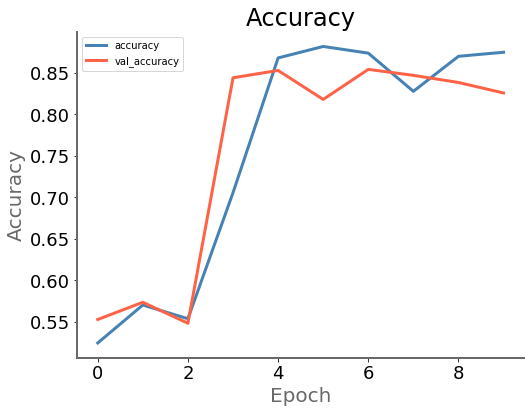

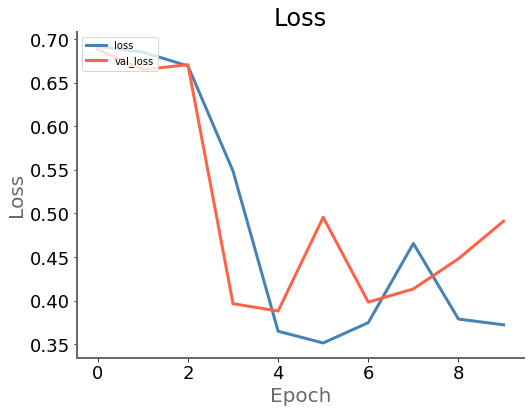

In [13]:
pwk.plot_history(history, save_as='02-history')

### 6.2 - Reload and evaluate best model

x_test / loss      : 0.3880
x_test / accuracy  : 0.8526


#### Accuracy donut is :

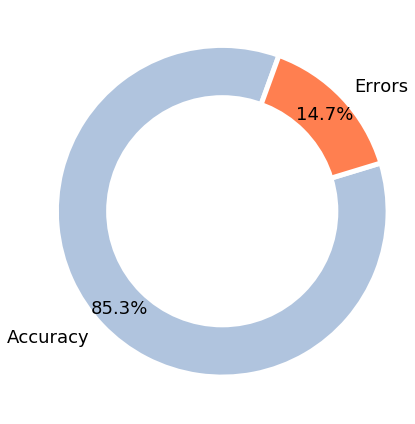

#### Confusion matrix is :

,0,1
0,0.81,0.19
1,0.10,0.90


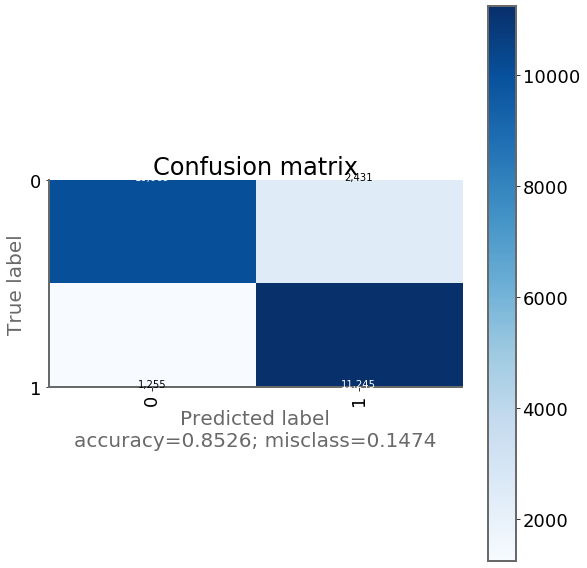

In [14]:
model = keras.models.load_model('./run/models/best_model.h5')

# ---- Evaluate
score  = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / accuracy  : {:5.4f}'.format(score[1]))

values=[score[1], 1-score[1]]
pwk.plot_donut(values,["Accuracy","Errors"], title="#### Accuracy donut is :", save_as='03-donut')

# ---- Confusion matrix

y_sigmoid = model.predict(x_test)

y_pred = y_sigmoid.copy()
y_pred[ y_sigmoid< 0.5 ] = 0
y_pred[ y_sigmoid>=0.5 ] = 1    

pwk.display_confusion_matrix(y_test,y_pred,labels=range(2))
pwk.plot_confusion_matrix(y_test,y_pred,range(2), figsize=(8, 8),normalize=False, save_as='04-confusion-matrix')

In [15]:
pwk.end()

End time is : Wednesday 27 January 2021, 19:19:51
Duration is : 00:07:34 809ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>